In [1]:
import os
import io

import detectron2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# Load VG Classes
data_path = 'data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())

MetadataCatalog.get("vg").thing_classes = vg_classes

In [3]:
import detectron2
print(detectron2.__version__)

import fvcore
print(fvcore.__version__)

0.1
0.1.1


In [4]:
cfg = get_cfg()
cfg.merge_from_file("../configs/VG-Detection/faster_rcnn_R_101_C4_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight
# cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe.pkl"
# cfg.MODEL_WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr_original.pkl"
predictor = DefaultPredictor(cfg)

Config '../configs/VG-Detection/faster_rcnn_R_101_C4_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.



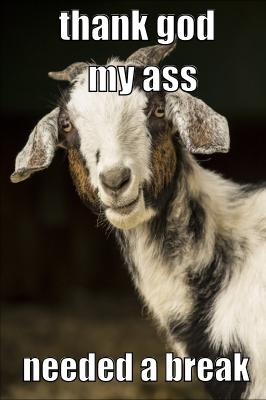

In [9]:
# im = cv2.imread("data/images/input.jpg")
im = cv2.imread('../../../data/img/62035.png')

im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
showarray(im_rgb)

In [10]:
NUM_OBJECTS = 100

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

def doit(raw_image):
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
        print("Original image size: ", (raw_height, raw_width))
        
        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
        print("Transformed image size: ", image.shape[:2])
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        
        # Generate proposals with RPN
        proposals, _ = predictor.model.proposal_generator(images, features, None)
        proposal = proposals[0]
        print('Proposal Boxes size:', proposal.proposal_boxes.tensor.shape)
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [x.proposal_boxes for x in proposals]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        print('Pooled features size:', feature_pooled.shape)
        
        # Predict classes and boxes for each proposal.
        pred_class_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        outputs = FastRCNNOutputs(
            predictor.model.roi_heads.box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
            predictor.model.roi_heads.smooth_l1_beta,
        )
        probs = outputs.predict_probs()[0]
        boxes = outputs.predict_boxes()[0]
        
        # Note: BUTD uses raw RoI predictions,
        #       we use the predicted boxes instead.
        # boxes = proposal_boxes[0].tensor    
        
        # NMS
        for nms_thresh in np.arange(0.5, 1.0, 0.1):
            instances, ids = fast_rcnn_inference_single_image(
                boxes, probs, image.shape[1:], 
                score_thresh=0.5, nms_thresh=nms_thresh, topk_per_image=NUM_OBJECTS
            )
            if len(ids) == NUM_OBJECTS:
                break
                
        instances = detector_postprocess(instances, raw_height, raw_width)
        roi_features = feature_pooled[ids].detach()
        print(instances)
        
        return instances, roi_features
    
instances, features = doit(im)

print(instances.pred_boxes)
print(instances.scores)
print(instances.pred_classes)
print(features)


Original image size:  (400, 266)
Transformed image size:  (1203, 800)
Proposal Boxes size: torch.Size([97, 4])
Pooled features size: torch.Size([97, 2048])
Instances(num_instances=18, image_height=400, image_width=266, fields=[pred_boxes, scores, pred_classes])
Boxes(tensor([[ 98.5400, 163.1013, 136.1264, 197.5545],
        [ 13.7739,  52.7473, 190.6264, 231.9119],
        [ 45.3552,  48.1399, 231.2684, 225.2827],
        [ 44.9088,  75.5668, 221.3794, 260.5957],
        [ 28.2567,  32.2568, 172.8132, 256.5906],
        [ 47.7174,  20.6409, 186.7193, 243.7859],
        [  0.4574,  68.5234, 179.7336, 256.0623],
        [ 52.8802,  46.4577, 206.0827, 282.4433],
        [ 36.1685,  28.4422, 217.7692, 199.9036],
        [  0.0000,  44.4681, 160.2475, 222.7453],
        [ 19.8417,  78.6100, 205.0285, 279.5252],
        [  1.8456,  35.5576, 208.2294, 216.8725],
        [ 70.8038,  22.2777, 221.8570, 249.5462],
        [ 44.0915,  70.5437, 180.1409, 281.9500],
        [ 51.8747,  78.4860, 211

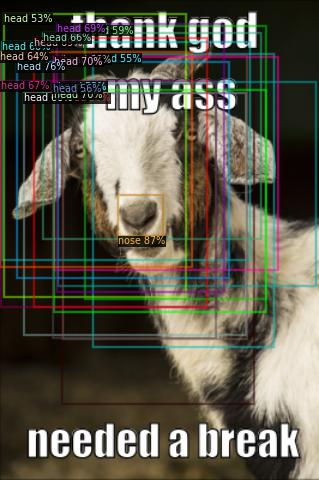

instances:
 Instances(num_instances=18, image_height=400, image_width=266, fields=[pred_boxes, scores, pred_classes])

boxes:
 Boxes(tensor([[ 98.5400, 163.1013, 136.1264, 197.5545],
        [ 13.7739,  52.7473, 190.6264, 231.9119],
        [ 45.3552,  48.1399, 231.2684, 225.2827],
        [ 44.9088,  75.5668, 221.3794, 260.5957],
        [ 28.2567,  32.2568, 172.8132, 256.5906],
        [ 47.7174,  20.6409, 186.7193, 243.7859],
        [  0.4574,  68.5234, 179.7336, 256.0623],
        [ 52.8802,  46.4577, 206.0827, 282.4433],
        [ 36.1685,  28.4422, 217.7692, 199.9036],
        [  0.0000,  44.4681, 160.2475, 222.7453],
        [ 19.8417,  78.6100, 205.0285, 279.5252],
        [  1.8456,  35.5576, 208.2294, 216.8725],
        [ 70.8038,  22.2777, 221.8570, 249.5462],
        [ 44.0915,  70.5437, 180.1409, 281.9500],
        [ 51.8747,  78.4860, 211.7177, 336.4166],
        [ 77.2698,  45.5301, 228.5440, 289.8400],
        [ 48.6741,  68.8520, 263.2419, 238.4388],
        [  3.3546

In [11]:
# Show the boxes, labels, and features
pred = instances.to('cpu')
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])
print('instances:\n', instances)
print()
print('boxes:\n', instances.pred_boxes)
print()
print('Shape of features:\n', features.shape)

In [8]:
# Verify the correspondence of RoI features
pred_class_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(features)
pred_class_probs = torch.nn.functional.softmax(pred_class_logits, -1)[:, :-1]
max_probs, max_classes = pred_class_probs.max(-1)
print("%d objects are different, it is because the classes-aware NMS process" % (NUM_OBJECTS - torch.eq(instances.pred_classes, max_classes).sum().item()))
print("The total difference of score is %0.4f" % (instances.scores - max_probs).abs().sum().item())

68 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.0000
